In [1]:
# importing libraries
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# Đường dẫn tới các file
ratings_path = "ratings.csv"
movies_path = "movies.csv"

In [20]:
top_users = ratings['userId'].value_counts().nlargest(1000).index
top_movies = ratings['movieId'].value_counts().nlargest(1000).index

In [22]:
filtered_ratings = ratings[
    (ratings['userId'].isin(popular_users)) & 
    (ratings['movieId'].isin(popular_movies))
]

In [23]:
file_path = movies.merge(filtered_ratings, how='inner', on='movieId')

In [35]:
print(file_path.head(10))

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
5        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
6        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
7        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
8        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
9        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0      28     4.0   961438127  
1     188     4.0  1103751789  
2     265     5.0  1607904458  
3    1048     4.0  16193

In [25]:
# Tạo ma trận (user x movie) để lưu ratings
users = data['userId'].unique()
movies = data['movieId'].unique()
ratings_matrix = pd.DataFrame(index=users, columns=movies)

In [26]:
# Điền giá trị ratings vào ma trận
for _, row in data.iterrows():
    ratings_matrix.loc[row['userId'], row['movieId']] = row['rating']

In [27]:
# Thay NaN bằng giá trị khởi tạo ngẫu nhiên (giả sử từ 1 đến 5)
ratings_matrix = ratings_matrix.applymap(lambda x: random.uniform(1, 5) if pd.isna(x) else x)

In [28]:
# Gibbs Sampling
num_iterations = 50  # Số vòng lặp Gibbs
for _ in range(num_iterations):
    for user in users:
        for movie in movies:
            # Lấy giá trị ratings khác để tính toán trung bình và phương sai
            others = ratings_matrix.loc[user, [col for col in movies if col != movie]]
            mean_rating = others.mean()
            std_rating = others.std() if others.std() > 0 else 1
            
            # Lấy mẫu từ phân phối Gaussian
            new_rating = np.random.normal(mean_rating, std_rating)
            # Cập nhật giá trị rating
            ratings_matrix.loc[user, movie] = max(1, min(5, new_rating)) 

In [29]:
print(ratings_matrix)

           0         1         2         3         4         5         6   \
0    2.598332  2.590956  2.573139  2.632159  2.601162  2.579354  2.589135   
1    3.884610  3.932647  3.879851  3.912423  3.901836  3.906851  3.877988   
2    4.260410  4.255768  4.256715  4.260021  4.260339  4.253436  4.256228   
3    3.355001  3.357109  3.428912  3.391413  3.402056  3.414035  3.389906   
4    3.400544  3.399705  3.400424  3.404125  3.410042  3.399752  3.398605   
..        ...       ...       ...       ...       ...       ...       ...   
195  3.556217  3.525223  3.637086  3.657826  3.752945  3.461821  3.641239   
196  2.865577  2.847771  2.853910  2.866568  2.854598  2.867054  2.858613   
197  3.034008  2.939015  2.957649  2.923045  2.941755  2.896680  2.942399   
198  2.705032  2.518523  2.551660  2.683657  2.705363  2.743295  2.638172   
199  3.626322  3.599262  3.565119  3.565207  3.634859  3.598896  3.579377   

           7         8         9   ...        44        45        46  \
0  

In [30]:
# Theo dõi sự hội tụ của một rating cụ thể
def track_rating_convergence(user, movie, num_iterations, ratings_matrix):
    # Chọn cặp (userId, movieId) để theo dõi
    tracked_ratings = []

    for _ in range(num_iterations):
        # Cập nhật rating (giống như trong Gibbs Sampling)
        others = ratings_matrix.loc[user, [col for col in movies if col != movie]]
        mean_rating = others.mean()
        std_rating = others.std() if others.std() > 0 else 1
        new_rating = np.random.normal(mean_rating, std_rating)
        new_rating = max(1, min(5, new_rating))  # Giới hạn trong [1, 5]
        ratings_matrix.loc[user, movie] = new_rating
        
        # Lưu giá trị để theo dõi
        tracked_ratings.append(new_rating)

    # Vẽ biểu đồ hội tụ
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_iterations), tracked_ratings, label=f"Rating for (user={user}, movie={movie})")
    plt.xlabel("Iterations")
    plt.ylabel("Rating")
    plt.title("Convergence of Gibbs Sampling")
    plt.legend()
    plt.show()

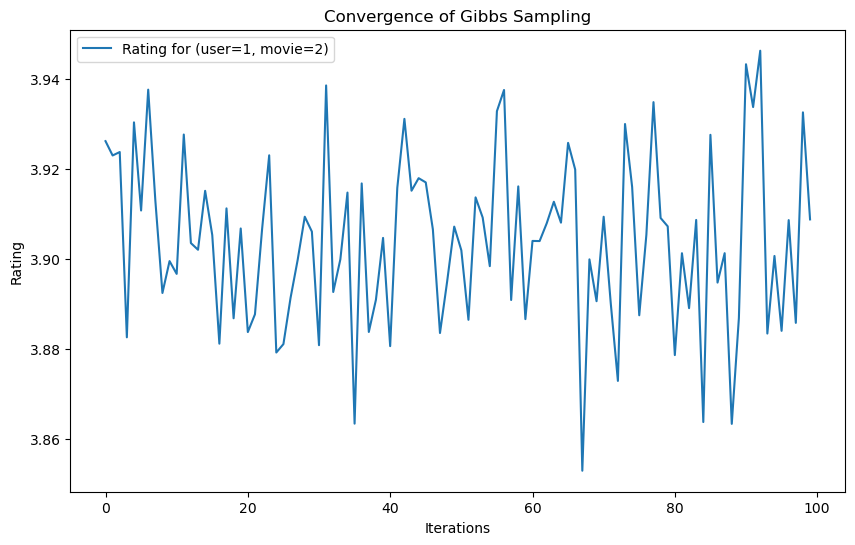

In [31]:
# Theo dõi sự hội tụ của một giá trị rating
track_rating_convergence(user=1, movie=2, num_iterations=100, ratings_matrix=ratings_matrix)

In [32]:
# Phân bố rating
def plot_rating_distribution(ratings_matrix):
    ratings = ratings_matrix.values.flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings, bins=20, kde=True)
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.title("Distribution of Ratings after Gibbs Sampling")
    plt.show()

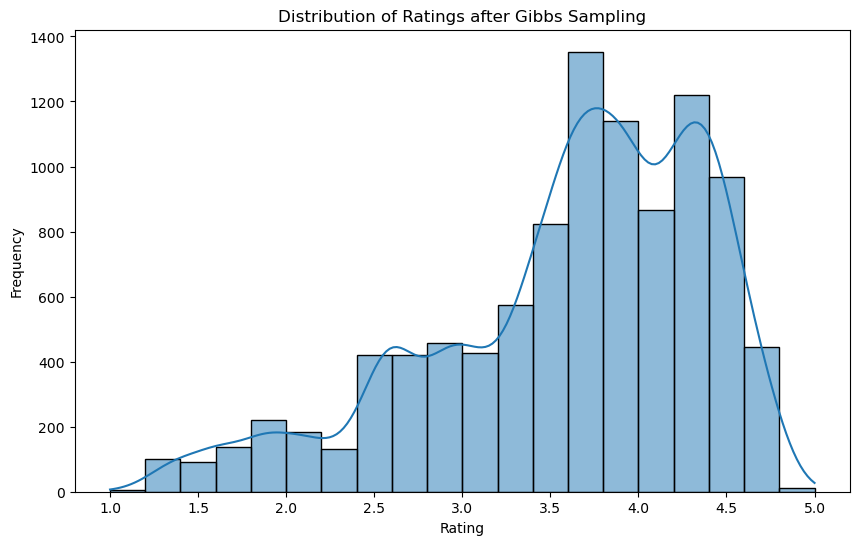

In [33]:
# Phân bố rating
plot_rating_distribution(ratings_matrix)